# Ames Housing Dataset

<p>I have chosen Ames Housing Dataset to study. The data set contains information from the Ames Assessor’s Office used in computing assessed values for individual residential properties sold in Ames, IA from 2006 to 2010. It has 82 columns which include 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers).</p><p>This data set was constructed for the purpose of an end of semester project for an undergraduate regression course. The original data (obtained directly from the Ames Assessor’s Office) is used for tax assessment purposes but lends itself directly to the prediction of home selling prices. The type of information contained in the data is similar to what a typical home buyer would want to know before making a purchase.</p><p>Some questions that can be asked are:
    
-  What are the variables that have the most influences on the sales price ?
-  How is the sales price distributed ?
-  Does the features shows multicollinearity ?
-  Do Overall Quality of the house affects the sale price ?
-  Do Sales Condition of the house affects the sale price ?
-  Do Sales Type of the house affects the sale price ?

In [1]:
% matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,LabelEncoder,Imputer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm,skew
from scipy import stats

In [2]:
data = pd.read_csv("train.csv")
obj_2 = data.select_dtypes(include = ['object'])
data.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


**Number of Columns & shape of the dataset**

In [3]:
columns = data.columns
print(columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
data.shape

(1460, 81)

List of columns in the dataset, and we can see that there are 80 columns in this dataset which mean that we might have to find a way to reduce the number of colums to reduce computational time and resources needed

In [5]:
categorical = ['MSSubClass','OverallQual','OverallCond']
for category in categorical:
    data[category] = data[category].astype('str')

Changing the numerical to categorical

# Data Cleaning

## Check for columns with large number of missing values and drop them

In [6]:
null = [column for column in columns if data[column].isnull().sum() > (0.5*len(data))]
print("Columns with missing value is:\n{}".format(null))

Columns with missing value is:
['Alley', 'PoolQC', 'Fence', 'MiscFeature']


In [7]:
for column in null:
    data.drop(column,axis = 1,inplace = True)
data.drop("Id",axis = 1, inplace = True)
columns = data.columns

## Fixing null values in remaining columns

In [8]:
missing = [column for column in columns if data[column].isnull().sum() > 0]
missing

['LotFrontage',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [9]:
# Lot Frontage
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [10]:
# MasVnrType and Area
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)

In [11]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')

In [12]:
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])

In [13]:
# FireplaceQu
data["FireplaceQu"] = data["FireplaceQu"].fillna("None")

In [14]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[col] = data[col].fillna('None')

In [15]:
# GarageYrBlt
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(0)

## Treatment of outliers in GrLivArea columns due to documentation advice

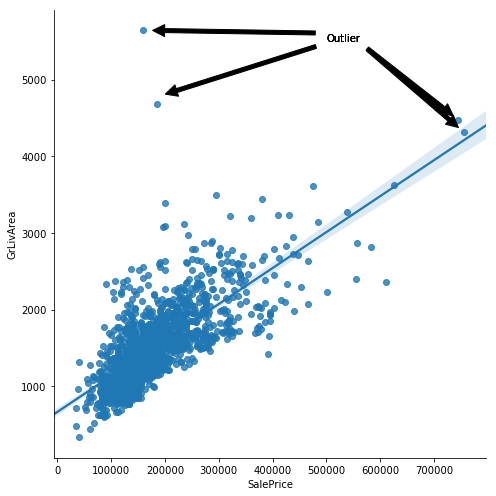

In [16]:
sns.lmplot('SalePrice','GrLivArea',size = 7,data = data)
plt.annotate('Outlier', xy=(160000,5642), xytext=(500000, 5500),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('Outlier', xy=(184750,4774), xytext=(500000, 5500),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('Outlier', xy=(755000,4316), xytext=(500000, 5500),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('Outlier', xy=(745000,4476), xytext=(500000, 5500),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

Outliers are one of those statistical issues that everyone knows about, but most people aren’t sure how to deal with. However before deciding on dropping the outlier, we need to make some considerations.

-  If it is obvious that the outlier is due to incorrectly entered or measured data, we should drop the outlier.<p>

- If the outlier does not change the results but does affect assumptions, we may drop the outlier.<p>

-  More commonly, the outlier affects both results and assumptions.  In this situation, it is not legitimate to simply drop the outlier.  We may run the analysis both with and without it, but we should state in at least a footnote the dropping of any such data points and how the results changed.<p>

-  If the outlier creates a significant association in the dataset(linear), we should drop the outlier and should not report any significance from the analysis.

## Removing the outliers

In [17]:
data = data[data['GrLivArea'] < 4000]
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


# Data Exploration

# How is the sales price distributed

In [18]:
data['SalePrice'].describe()

count      1456.000000
mean     180151.233516
std       76696.592530
min       34900.000000
25%      129900.000000
50%      163000.000000
75%      214000.000000
max      625000.000000
Name: SalePrice, dtype: float64

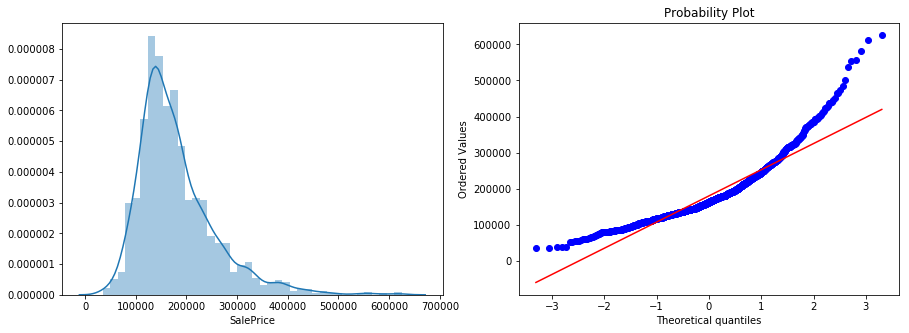

In [19]:
fig,(ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
_ = sns.distplot(data['SalePrice'],ax = ax1)
_ = stats.probplot(data['SalePrice'], plot=plt)

It seems that the sale price distribution differs from normal distribution, which means that we might need to normalize the value before running the data through machine learning algorithm. The distribution is also leptokurtic and has positive skewness. We will now apply log transformation to the column SalePrice.

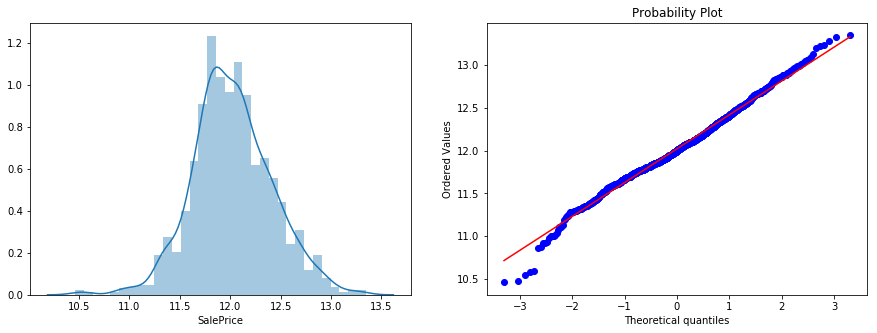

In [20]:
data['SalePrice'] = np.log(data['SalePrice'])
fig,(ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
_ = sns.distplot(data['SalePrice'],ax = ax1)
_ = stats.probplot(data['SalePrice'],plot=plt)

That looks much better now !

## Relationship between sale price and other numerical columns

### Which features are highly correlated with the sales price ?

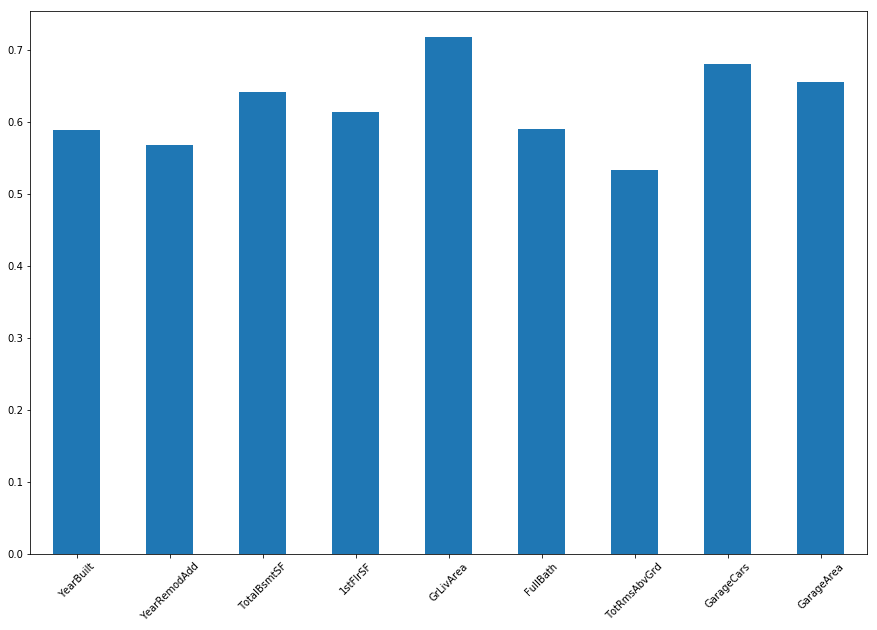

In [21]:
num = data.select_dtypes(include = ['int64','float64'])
corr = num.corr().loc['SalePrice']
corr[corr >= 0.5][:-1].plot(kind = 'bar',figsize = (15,10), rot = 45)

In [22]:
num = num[['YearBuilt','YearRemodAdd','TotalBsmtSF', '1stFlrSF', 'GrLivArea',
           'FullBath','TotRmsAbvGrd','GarageCars', 'GarageArea','SalePrice']]
num.head()

,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice
0,2003,2003,856,856,1710,2,8,2,548,12.247694
1,1976,1976,1262,1262,1262,2,6,2,460,12.109011
2,2001,2002,920,920,1786,2,6,2,608,12.317167
3,1915,1970,756,961,1717,1,7,3,642,11.849398
4,2000,2000,1145,1145,2198,2,9,3,836,12.429216


All this columns have significant effects on the sales prices

## Relationship of variables with each other

### Does the variable shows multicollinearity ?

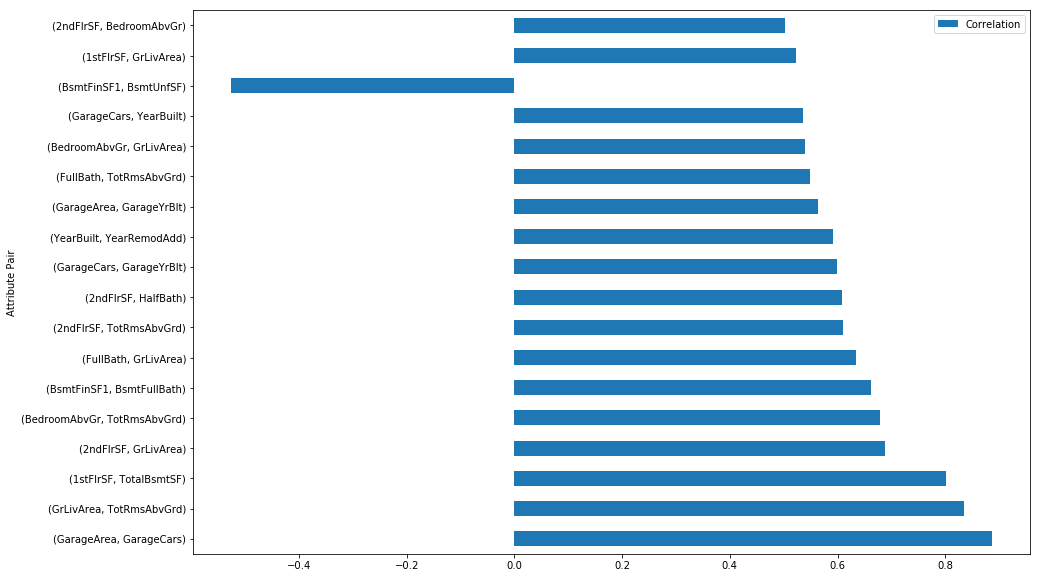

In [23]:
correlations=data.corr()
attrs = correlations.iloc[:-1,:-1] # all except target

threshold = 0.5
important_corrs = (attrs[abs(attrs) > threshold][attrs != 1.0]) \
    .unstack().dropna().to_dict()

unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])), 
        columns=['Attribute Pair', 'Correlation'])

    # sorted by absolute value
unique_important_corrs = unique_important_corrs.loc[
    abs(unique_important_corrs['Correlation']).argsort()[::-1]]
plt.figure(dpi = 200)
unique_important_corrs.plot(x = 'Attribute Pair', y = 'Correlation',kind = 'barh',figsize =(15,10))

This is an example of multicollinearity.

Multicollinearity generally occurs when there are high correlations between two or more predictor variables. In other words, one predictor variable can be used to predict the other. This creates redundant information, skewing the results in a regression model. Examples of correlated predictor variables (also called multicollinear predictors) are: a person’s height and weight, age and sales price of a car, or years of education and annual income.<p>

To avoid this we can do 3 things:

- Completely remove those variables
- Make new feature by adding them or by some other operation.
- Use PCA, which will reduce feature set to small number of non-collinear features.

## Do Overall Quality of the house affects the sale price ?

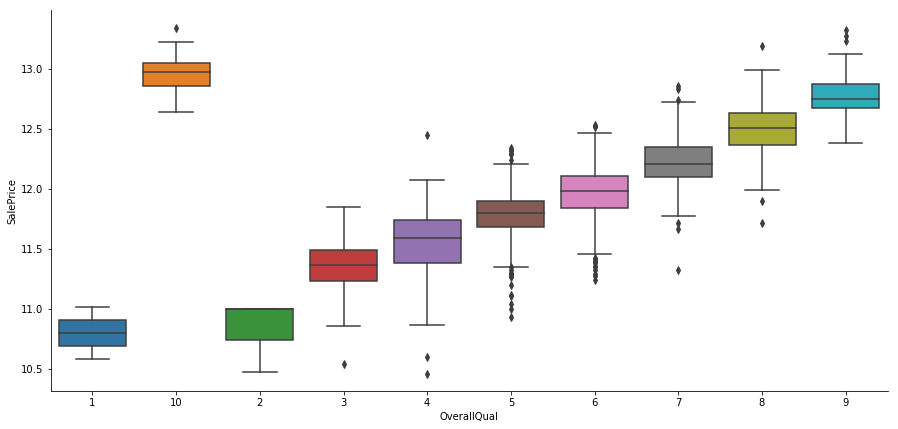

In [24]:
obj = data.select_dtypes(include = ['object'])
obj_2 = data.select_dtypes(include = ['object'])
data_object = pd.concat([num['SalePrice'],obj['OverallQual']],axis = 1)
plt.figure(figsize = (15,7))
sns.boxplot(x = 'OverallQual', y = 'SalePrice',data = data)
sns.despine()

Overall Qual (Ordinal): Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor

It is easy to see that overall quality of the house matters quite a lot in term of the final sale price

## Do Sales Condition of the house affects the sale price ?

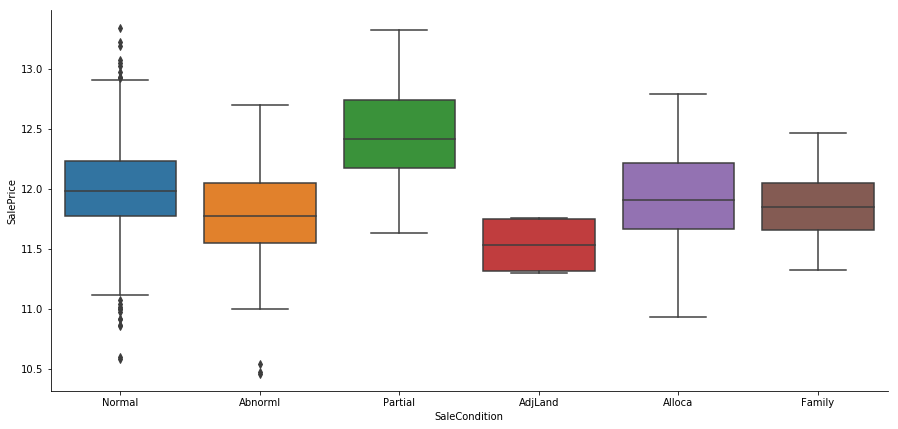

In [25]:
data_object = pd.concat([num['SalePrice'],obj['SaleCondition']],axis = 1)
plt.figure(figsize = (15,7))
sns.boxplot(x = 'SaleCondition', y = 'SalePrice',data = data)
sns.despine()

Sale Condition (Nominal): Condition of sale

Normal - Normal Sale<p>
    
Abnorml - Abnormal Sale -  trade, foreclosure, short sale<p>
AdjLand - Adjoining Land Purchase<p>
Alloca - Allocation - two linked properties with separate deeds, typically condo with a garage unit
Family - Sale between family members<p>
Partial - Home was not completed when last assessed (associated with New Homes)

From the box plot we can see that the price of normal house has more spread than any of the other type of sale condition. Sales within family on the other hand, shows a small spread which makes sense because people tend to value their family more and decide to not charge an exorbitant price. Partial home which is new house has higher mean price value than other type of sales condition. Therefore, i do think sale condition has low impact on the sales price except for new houses.

## Do Sales Type of the house affects the sale price ?

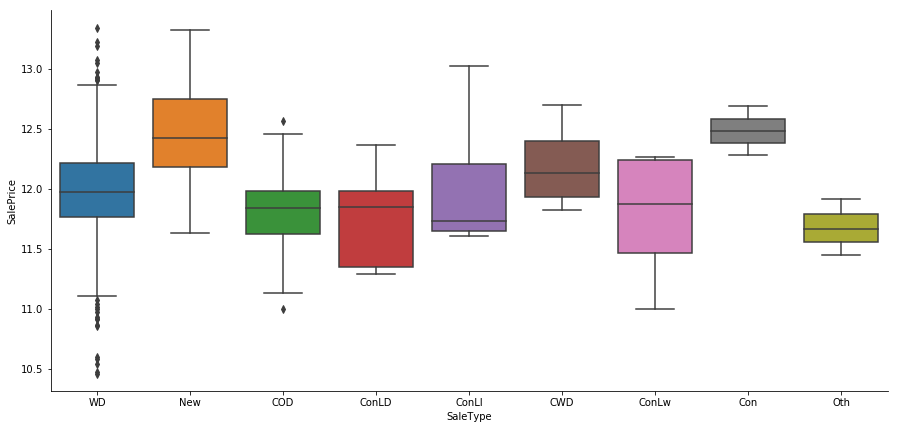

In [26]:
data_object = pd.concat([num['SalePrice'],obj['SaleType']],axis = 1)
plt.figure(figsize = (15,7))
sns.boxplot(x = 'SaleType', y = 'SalePrice',data = data)
sns.despine()

# Preparation before feeding data into machine learning algorithm

## Check for skewness in numerical data

In [27]:
target = data['SalePrice']
data = data.iloc[:,:-1]

skewness = data.select_dtypes(include = ['int64','float64']).columns
skewed_feats = data[skewness].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

,Skew
MiscVal,24.418175
PoolArea,17.504556
LotArea,12.574590
3SsnPorch,10.279262
LowQualFinSF,8.989291
KitchenAbvGr,4.476748
BsmtFinSF2,4.244209
BsmtHalfBath,4.124712
ScreenPorch,4.111400
EnclosedPorch,3.081275


In [28]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transformed".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    data[feat] = boxcox1p(data[feat], lam)

There are 33 skewed numerical features to Box Cox transformed


## Getting dummy for categorical features

In [29]:
le = LabelEncoder()
obj = obj.apply(le.fit_transform)
data = pd.get_dummies(data)
data.shape

(1456, 315)

In [30]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train, y_test = train_test_split(data,target,random_state = 1)

# Modelling 

In this part of the notebook, we will run the dataset through various machine learning algorithms and evaluate the result according to Root Mean Squared Error between the true value and the predicted value.
Root Mean Squared Error(RMSE) can be defined as square root of the mean square (the arithmetic mean of the squares of a set of numbers). In the modelling process we will be using vanilla version of the dataset without feature selection and try to find the best algorithm for the dataset. These three algorithm is Lasso, Elastic Net and Gradient Boosting Regressor.

### Importing libraries

In [31]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split,GridSearchCV,ShuffleSplit,learning_curve
from sklearn.metrics import mean_squared_error

### Validation Function

In [32]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Initialize all base models

In [33]:
lasso = make_pipeline(RobustScaler(), Lasso(random_state = 3))
ENet = make_pipeline(RobustScaler(),ElasticNet(random_state=3))
GBoost = GradientBoostingRegressor(random_state =3)

### Results

In [34]:
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("Elastic Net score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 0.3662 (0.0108)

Elastic Net score: 0.3657 (0.0110)

Gradient Boosting score: 0.1315 (0.0126)



## Can we improve the algorithm ? 

### Grid Search for Lasso

In [35]:
clf = Lasso(random_state = 3)
grid_values = {'alpha': [0.001, 0.01, 0.05, 0.1, 1, 10, 100]}

# default metric to optimize over grid parameters: accuracy
grid_clf_acc = GridSearchCV(clf,scoring = 'neg_mean_squared_error', cv = 5,param_grid = grid_values)
grid_clf_acc.fit(X_train, y_train)

print('Grid best parameter (Min. Mean Squared Error): ', grid_clf_acc.best_params_)
print('Grid best score (Mean Squared Error): ', grid_clf_acc.best_score_)

Grid best parameter (Min. Mean Squared Error):  {'alpha': 0.001}
Grid best score (Mean Squared Error):  -0.0136846732482


### Grid Search for Elastic Net

In [36]:
clf = ElasticNet(random_state = 3)
grid_values = {'alpha': [0.001, 0.01, 0.05, 0.1, 1, 10, 100],
               'l1_ratio': [0.1,0.3,0.5,0.7,0.9]}

# default metric to optimize over grid parameters: accuracy
grid_clf_acc = GridSearchCV(clf,scoring = 'neg_mean_squared_error', cv = 5,param_grid = grid_values)
grid_clf_acc.fit(X_train, y_train)

print('Grid best parameter (Min. Mean Squared Error): ', grid_clf_acc.best_params_)
print('Grid best score (Mean Squared Error): ', grid_clf_acc.best_score_)

Grid best parameter (Min. Mean Squared Error):  {'alpha': 0.001, 'l1_ratio': 0.3}
Grid best score (Mean Squared Error):  -0.0125506319811


### Grid Search for Gradient Boosting

In [37]:
clf = GradientBoostingRegressor(warm_start = True,random_state = 3)
grid_values = {'loss': ['ls','huber'],
               'learning_rate': [0.1,0.5],
               'max_depth': [3,5],
               'n_estimators': [100,300]}

# default metric to optimize over grid parameters: accuracy
grid_clf_acc = GridSearchCV(clf,scoring = 'neg_mean_squared_error', cv = 2,param_grid = grid_values)
grid_clf_acc.fit(X_train, y_train)

print('Grid best parameter (Min. Mean Squared Error): ', grid_clf_acc.best_params_)
print('Grid best score (Mean Squared Error): ', grid_clf_acc.best_score_)

Grid best parameter (Min. Mean Squared Error):  {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 3, 'n_estimators': 300}
Grid best score (Mean Squared Error):  -0.0179818099182


### Initialize all tuned models

In [38]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.001,random_state = 3))
ENet = make_pipeline(RobustScaler(),ElasticNet(alpha = 0.001, l1_ratio = 0.3,random_state=3))
GBoost = GradientBoostingRegressor(learning_rate = 0.1, loss = 'huber', max_depth = 3,n_estimators = 300,random_state =3)

In [39]:
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("Elastic Net score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 0.1127 (0.0131)

Elastic Net score: 0.1094 (0.0134)

Gradient Boosting score: 0.1221 (0.0121)



From this we can see that the best algorithm for the dataset is Elastic Net. Gradient has too much parameters that requires time to tune and the tradeoff between training time and performance isnt really worth it.

In [40]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize = (15,7))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes,train_scores,test_scores = learning_curve(
        estimator, X, y,scoring = 'neg_mean_squared_error',cv=cv, n_jobs=n_jobs, 
        train_sizes=train_sizes)
    train_scores_mean = abs(np.mean(train_scores, axis=1))
    train_scores_std = abs(np.std(train_scores, axis=1))
    test_scores_mean = abs(np.mean(test_scores, axis=1))
    test_scores_std = abs(np.std(test_scores, axis=1))
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Parmenides\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

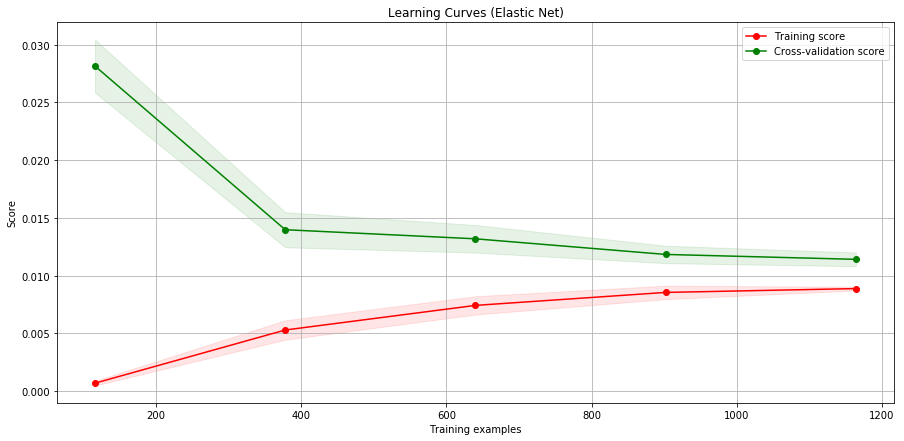

In [41]:
title = "Learning Curves (Elastic Net)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = ENet
plot_learning_curve(estimator, title, data, target, cv=cv, n_jobs=4)

From the learning curve we can see that the cross validation score increase dramatically with more training sample. However between 800 -1000, the improvement seems to falter. Which means that we might need a better model to improve the performance. However due to the constraint of processing resources, this is a good and quick model.

# Predicting the test set

In [42]:
ENet.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.3,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=3, selection='cyclic', tol=0.0001, warm_start=False))])

In [43]:
y_pred = ENet.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
rmse

0.11810383800176444